# Modeling Energy Levels with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the ENSDF Dataset and builds a model to predict the level energy of several isotopes. To do this, we'll provide the model with a description of many expeirmentally measrued values and accepted values. This description includes attributes like: # of neutrons, # of protons, and Atomic Mass.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import importlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os
import importlib

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

1.15.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [13]:
sns.set(font_scale=2)

In [15]:
from Utilities import ENSDF_plotting_nn as ensdf_plot
from Utilities import ENSDF_utilities as ensdf_utils
importlib.reload(ensdf_plot)
importlib.reload(ensdf_utils)

<module 'Utilities.ENSDF_utilities' from 'C:\\Users\\vicen\\Desktop\\ML_Nuclear_Data\\Utilities\\ENSDF_utilities.py'>

# Getting the Data: ENSDF/RIPL Known and Cut-Off
# Creating Training, Validation, and Testing Datasets and Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

In [14]:
train_size = 0.8
test_size = 1 - 0.8

In [17]:
df, x_train, x_test, y_train, y_test, to_scale, scaler = ensdf_utils.load_ensdf(
    "./ENSDF/ensdf_v2_2.csv", numerical=True, duplicate=False, give_split=True, frac=test_size, norm=True, log_e=False)

Reading data into dataframe...
Data read into dataframe with shape:  (21355, 8)
Converting data to numerical...
Splitting dataset into training and testing...
Normalizing dataset..
Finished.


# Known Upper Levels 

In [16]:
df, x_train_all, x_test_all, y_train_all, y_test_all, to_scale, scaler_all = ensdf_utils.load_ensdf(
    "./ENSDF/ensdf_v1_2.csv", numerical=True, duplicate=False, give_split=True, frac=test_size, norm=True, log_e=False)

Reading data into dataframe...
Data read into dataframe with shape:  (72668, 8)
Converting data to numerical...
Splitting dataset into training and testing...
Normalizing dataset..
Finished.


# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

# Neural Networks

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

If the model is not complex enough and its left training for emore than necessary the accuracy of the model stagnates or start decreasing. This is a sympton of overfitting. Overfit often translates to higher accuracies on the training dataset but does not generalize well to a testing set. The opposite is underfiting (not trained for long enough or the model is not complex enough) meaning model not powerful enough or over regularized. 

The network needs to learn relevant patters in the data. If training for too long it learns the weights to memorize and not model the data. We need to strike a balance between both. How many epochs do we train for? How much regularization?

Prevent overfitting by:
- More complete training data (dataset must cover full range of inputs that it is expected to handle).
- Additional data is needed to cover other cases
- If no more data gathering is possible we need to use regularization
- Regularization places constraints on the quantity and type of information your model can store.

At the end is all about learnable parameters which is determined by the # of layers and the units per layer. The number of learnable parameters is referred to as the models capacity. It is apparent that we can increase the models capacity to a point that it learns a perfect dictionary-like-mapping between datapoints and their targets but with no generalization power (useless on unseen data). 

If model is not complex enough it will learn compresssed representations which is not able to generalize well. There is a balance between too much and not much capacity. There is no methodology or formula to determine arquitecture size. We start with very few layers and parameteres and slowly increase the size of layers until we see diminishing validation loss

The strategy.scope() indicates part of the code to run distributed, creating model inside scope allows us to create mirrored vairables, compiling under the scope tells TF our intend to train model using this strategy.

In [22]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Optimization - Learning Rate

A gradually reducing learning rate with time performes better (jumping around). The `schedules.InverseTimeDecay` decreases rate hyperbolicallly to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 and so on.

# Compile and Fit Funciton - TensorBoard Logs

In [23]:
def get_optimizer(lr_schedule):
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200), # val_loss
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE=None, 
                    optimizer=None, max_epochs=10000, DECAY_EPOCHS=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=STEPS_PER_EPOCH*DECAY_EPOCHS,
        decay_rate=1, staircase=False)
    
    if optimizer is None:
        optimizer = get_optimizer(lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(
        train_dataset,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=test_dataset,
        callbacks=get_callbacks(name),
        verbose=0)        
    return history

In [24]:
cpu_strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
single_gpu_strategy =  tf.distribute.OneDeviceStrategy(device="/GPU:0")
gpu_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(gpu_strategy.num_replicas_in_sync))

Number of devices: 2


# Create a tf.data.Dataset Generator

The larger the `BATCH_SIZE`, the more efficient TensorFlow operates. 

In [25]:
N_VALIDATION = len(x_test)
N_TRAIN = len(x_train)
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 500
FEATURES = len(x_train.columns)

In [26]:
def tf_dataset_gen(x, y, xt, yt, BUFFER_SIZE, BATCH_SIZE, gpu=False, multiplier=0, cache=False):
    if gpu == True:
        BATCH_SIZE = BATCH_SIZE * multiplier
        print("GPU: ON")
    train_dataset = tf.data.Dataset.from_tensor_slices((x.values, y.values)).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((xt.values, yt.values)).batch(BATCH_SIZE)
    if cache == True: # Ensures loader doesnt re-read data at each epoch.
        train_dataset = train_dataset.cache()
        test_dataset = test_dataset.cache()
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    print("BATCH SIZE: ", BATCH_SIZE)
    print("STEPS PER EPOCH: ", STEPS_PER_EPOCH)
    return train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE

In [27]:
train_dataset, test_dataset, STEPS_PER_EPOCH_CPU, BATCH_SIZE_CPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, BATCH_SIZE)

BATCH SIZE:  500
STEPS PER EPOCH:  34


In [28]:
train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, BATCH_SIZE_GPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, 3000, gpu=True, multiplier=2)

GPU: ON
BATCH SIZE:  6000
STEPS PER EPOCH:  2


# Training Models

In [29]:
size_histories = {}
size_histories_gpu = {}

In [30]:
%%time
with cpu_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(1)])
    size_histories['Tiny_CPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_CPU', train_dataset, 
                                                 test_dataset, STEPS_PER_EPOCH_CPU, max_epochs=5000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.3034,  mae:2.0096,  mse:8.3034,  val_loss:6.5230,  val_mae:1.8357,  val_mse:6.5674,  
....................................................................................................
Epoch: 100, loss:1.5575,  mae:0.8929,  mse:1.5575,  val_loss:1.3548,  val_mae:0.8623,  val_mse:1.3653,  
....................................................................................................
Epoch: 200, loss:1.2873,  mae:0.8391,  mse:1.2873,  val_loss:1.1371,  val_mae:0.8117,  val_mse:1.1446,  
......

To infer shape is  (538, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.21666527820731485
The R2-Score is:  0.8822985693765808
The MAE is:  0.4225376903418489
The Median-AE is:  0.45073226737976047


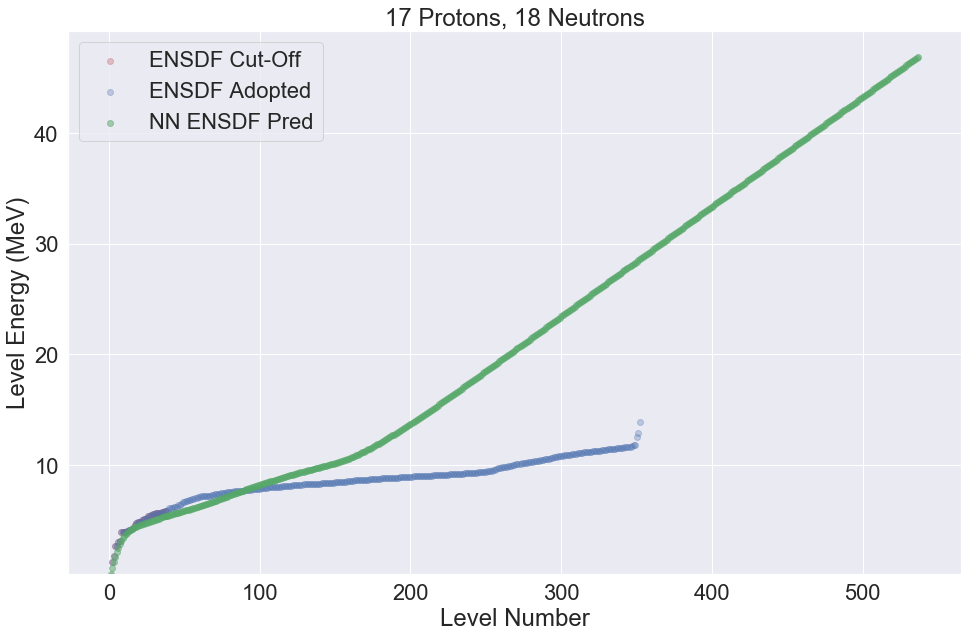

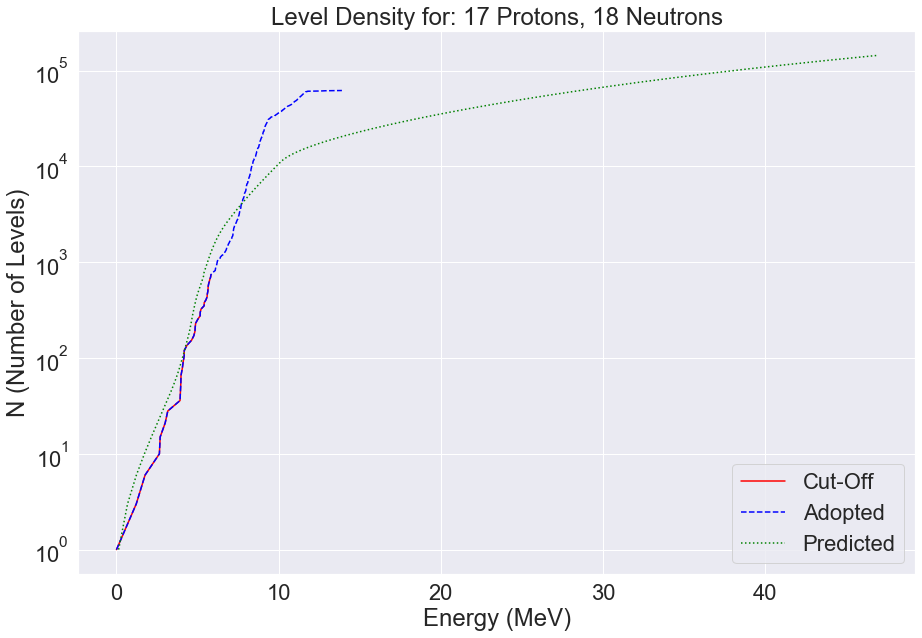

In [34]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, size_histories['Tiny_CPU'].model, scaler, to_scale, 
                                               N=500, adopted=True, xg=False, tf_dataset=True, save=False, name="Cl35")

In [42]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_1000'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=1000)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
__________________________

InternalError: 3 root error(s) found.
  (0) Internal:  Blas GEMM launch failed : a.shape=(3000, 4), b.shape=(4, 16), m=3000, n=16, k=4
	 [[node sequential_1/dense_2/MatMul (defined at \site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
	 [[metrics/mse/div_no_nan/ReadVariableOp_2/_78]]
  (1) Internal:  Blas GEMM launch failed : a.shape=(3000, 4), b.shape=(4, 16), m=3000, n=16, k=4
	 [[node replica_1/sequential_1/dense_2/MatMul (defined at \site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
  (2) Internal:  Blas GEMM launch failed : a.shape=(3000, 4), b.shape=(4, 16), m=3000, n=16, k=4
	 [[node sequential_1/dense_2/MatMul (defined at \site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_48271]

Function call stack:
distributed_function -> distributed_function -> distributed_function


In [77]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_500'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=500)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.2373,  mae:1.9376,  mse:7.2373,  val_loss:6.6418,  val_mae:1.9241,  val_mse:7.5297,  
....................................................................................................
Epoch: 100, loss:1.7231,  mae:0.9320,  mse:1.7231,  val_loss:1.8755,  val_mae:0.9719,  val_mse:2.0403,  
....................................................................................................
Epoch: 200, loss:1.5686,  mae:0.8999,  mse:1.5686,  val_loss:1.7759,  val_mae:0.9505,  val_mse:1.9306,  
....

In [129]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_15000'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.5461,  mae:2.3325,  mse:8.5461,  val_loss:7.8412,  val_mae:2.3296,  val_mse:8.9764,  
....................................................................................................
Epoch: 100, loss:1.7125,  mae:0.9095,  mse:1.7125,  val_loss:1.8699,  val_mae:0.9565,  val_mse:2.0348,  
....................................................................................................
Epoch: 200, loss:1.7021,  mae:0.9115,  mse:1.7021,  val_loss:1.7757,  val_mae:0.9449,  val_mse:1.9357,  
...

....................................................................................................
Epoch: 7700, loss:1.0362,  mae:0.7820,  mse:1.0362,  val_loss:1.0426,  val_mae:0.7987,  val_mse:1.1754,  
....................................................................................................
Epoch: 7800, loss:1.0473,  mae:0.7820,  mse:1.0473,  val_loss:1.0421,  val_mae:0.7986,  val_mse:1.1749,  
....................................................................................................
Epoch: 7900, loss:1.0399,  mae:0.7811,  mse:1.0399,  val_loss:1.0413,  val_mae:0.7984,  val_mse:1.1741,  
....................................................................................................
Epoch: 8000, loss:1.0456,  mae:0.7821,  mse:1.0456,  val_loss:1.0407,  val_mae:0.7983,  val_mse:1.1736,  
....................................................................................................
Epoch: 8100, loss:1.0454,  mae:0.7794,  mse:1.0454,  val_loss:1.0401,  

....................................................................................................
Epoch: 11700, loss:1.0195,  mae:0.7734,  mse:1.0195,  val_loss:1.0244,  val_mae:0.7953,  val_mse:1.1575,  
....................................................................................................
Epoch: 11800, loss:1.0046,  mae:0.7718,  mse:1.0046,  val_loss:1.0241,  val_mae:0.7952,  val_mse:1.1572,  
....................................................................................................
Epoch: 11900, loss:1.0167,  mae:0.7759,  mse:1.0167,  val_loss:1.0239,  val_mae:0.7952,  val_mse:1.1569,  
....................................................................................................
Epoch: 12000, loss:1.0007,  mae:0.7682,  mse:1.0007,  val_loss:1.0235,  val_mae:0.7951,  val_mse:1.1566,  
....................................................................................................
Epoch: 12100, loss:1.0022,  mae:0.7708,  mse:1.0022,  val_loss:1.02

In [132]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_72 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_73 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_74 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_75 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_76 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_77 (Dense)             (None, 16)              

....................................................................................................
Epoch: 2800, loss:0.5971,  mae:0.5941,  mse:0.5971,  val_loss:0.5462,  val_mae:0.5990,  val_mse:0.6487,  
....................................................................................................
Epoch: 2900, loss:0.5764,  mae:0.5843,  mse:0.5764,  val_loss:0.5198,  val_mae:0.5954,  val_mse:0.6241,  
....................................................................................................
Epoch: 3000, loss:0.5689,  mae:0.5806,  mse:0.5689,  val_loss:0.5175,  val_mae:0.5927,  val_mse:0.6225,  
....................................................................................................
Epoch: 3100, loss:0.5668,  mae:0.5822,  mse:0.5668,  val_loss:0.5126,  val_mae:0.5938,  val_mse:0.6182,  
....................................................................................................
Epoch: 3200, loss:0.5671,  mae:0.5809,  mse:0.5671,  val_loss:0.5117,  

....................................................................................................
Epoch: 6800, loss:0.5021,  mae:0.5525,  mse:0.5021,  val_loss:0.4646,  val_mae:0.5715,  val_mse:0.5615,  
....................................................................................................
Epoch: 6900, loss:0.5095,  mae:0.5559,  mse:0.5095,  val_loss:0.4635,  val_mae:0.5721,  val_mse:0.5597,  
....................................................................................................
Epoch: 7000, loss:0.5040,  mae:0.5545,  mse:0.5040,  val_loss:0.4623,  val_mae:0.5735,  val_mse:0.5591,  
....................................................................................................
Epoch: 7100, loss:0.4983,  mae:0.5505,  mse:0.4983,  val_loss:0.4609,  val_mae:0.5741,  val_mse:0.5576,  
....................................................................................................
Epoch: 7200, loss:0.5055,  mae:0.5532,  mse:0.5055,  val_loss:0.4646,  

In [133]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp112'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp112', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 112)               560       
_________________________________________________________________
dense_88 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_89 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_90 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_91 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_92 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_93 (Dense)             (None, 112)             

In [134]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='relu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp_relu'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp_relu', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 112)               560       
_________________________________________________________________
dense_104 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_105 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_106 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_107 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_108 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_109 (Dense)            (None, 112)             

In [104]:
# plt.figure(figsize=(15,10))
# plotter = tfdocs.plots.HistoryPlotter(metric='mae', smoothing_std=5)
# plotter.plot(size_histories)
# plt.ylim()
# plt.ylabel('MAE [MeV]')

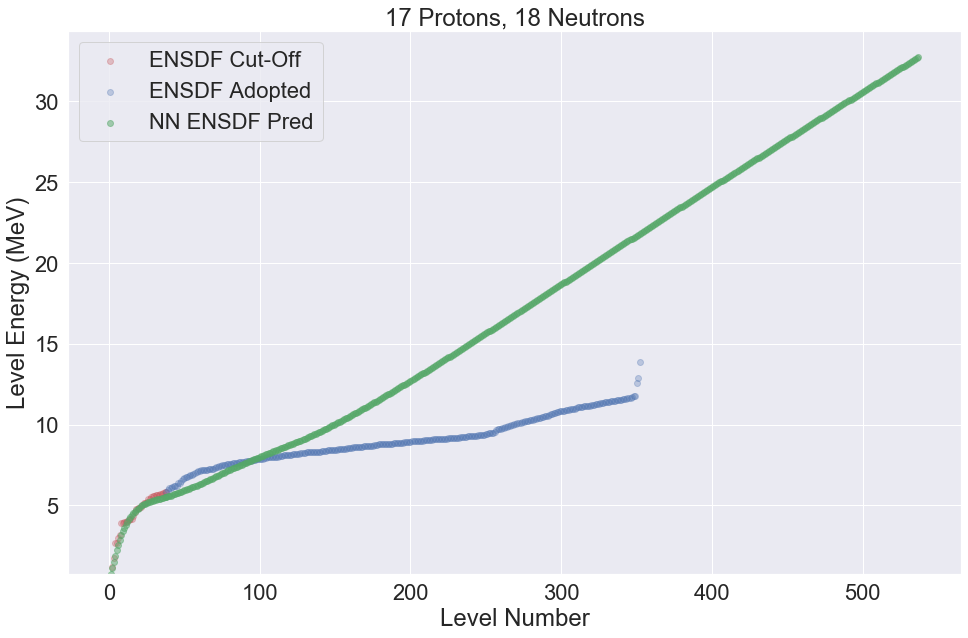

XS Tree vs EXFOR:
The MSE is:  0.10241385001735825
The R2-Score is:  0.9443646127222964


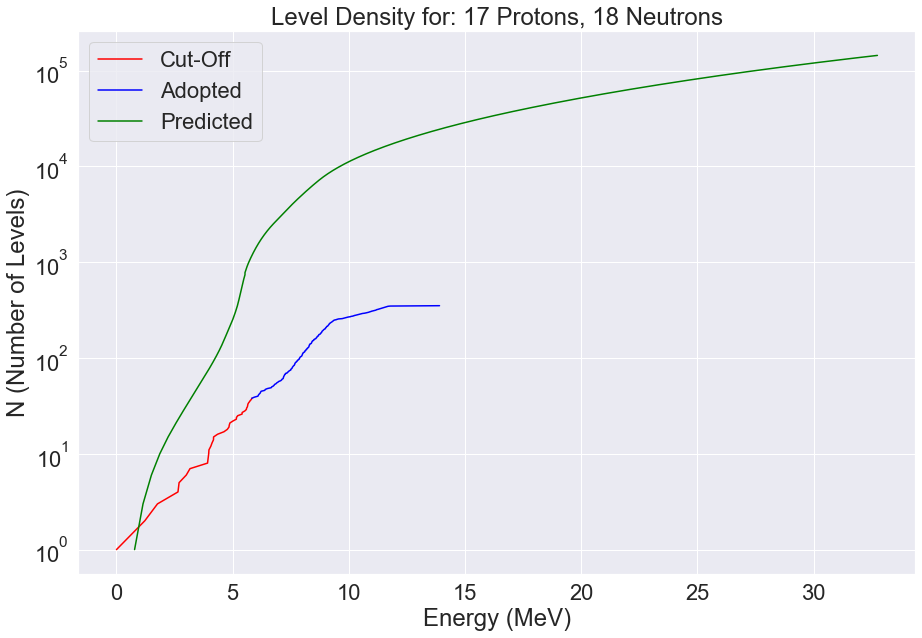

In [100]:
predicting_nuclear_xs(17, 35-17, size_histories['Tiny_GPU_1000'].model, N=500, adopted=True, tf_dataset=True)

In [36]:
%%time
with gpu_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['Medium_GPU'] = compile_and_fit(medium_model, 'sizes/Medium_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, nu

....................................................................................................
Epoch: 3400, loss:0.7749,  mae:0.6701,  mse:0.7749,  val_loss:0.7617,  val_mae:0.6671,  val_mse:0.7646,  
....................................................................................................
Epoch: 3500, loss:0.7713,  mae:0.6664,  mse:0.7713,  val_loss:0.7666,  val_mae:0.6648,  val_mse:0.7698,  
....................................................................................................
Epoch: 3600, loss:0.7696,  mae:0.6683,  mse:0.7696,  val_loss:0.7600,  val_mae:0.6711,  val_mse:0.7631,  
....................................................................................................
Epoch: 3700, loss:0.7564,  mae:0.6653,  mse:0.7564,  val_loss:0.7613,  val_mae:0.6648,  val_mse:0.7650,  
....................................................................................................
Epoch: 3800, loss:0.7466,  mae:0.6581,  mse:0.7466,  val_loss:0.7530,  

In [103]:
%%time
with gpu_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['Large_GPU'] = compile_and_fit(large_model, 'sizes/Large_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:6.0947,  mae:1.8758,  mse:6.0947,  val_loss:3.0227,  val_mae:1.3794,  val_mse:3.3841,  
.........

Text(0.5, 0, 'Epochs [Log Scale]')

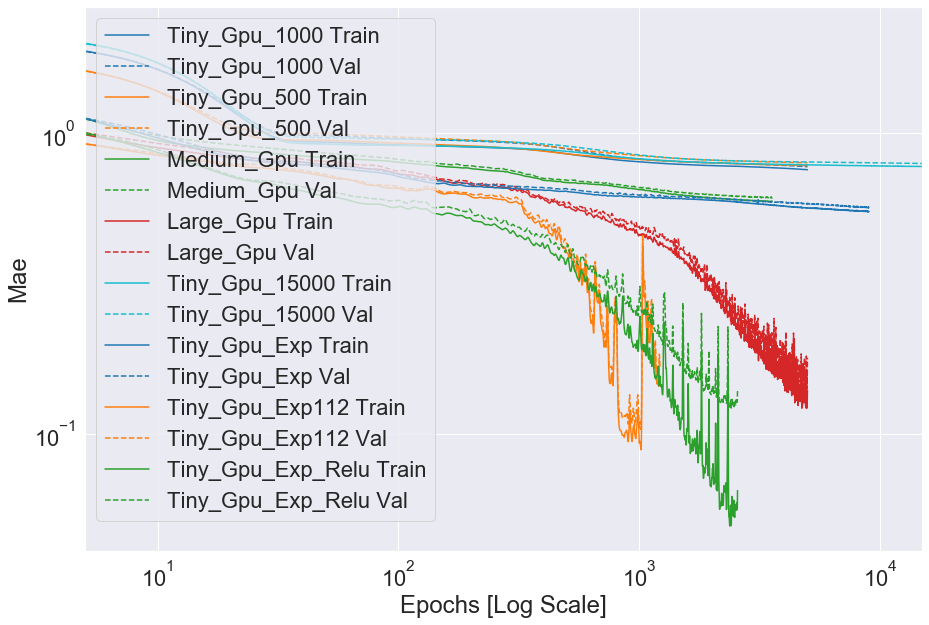

In [135]:
plt.figure(figsize=(15,10))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

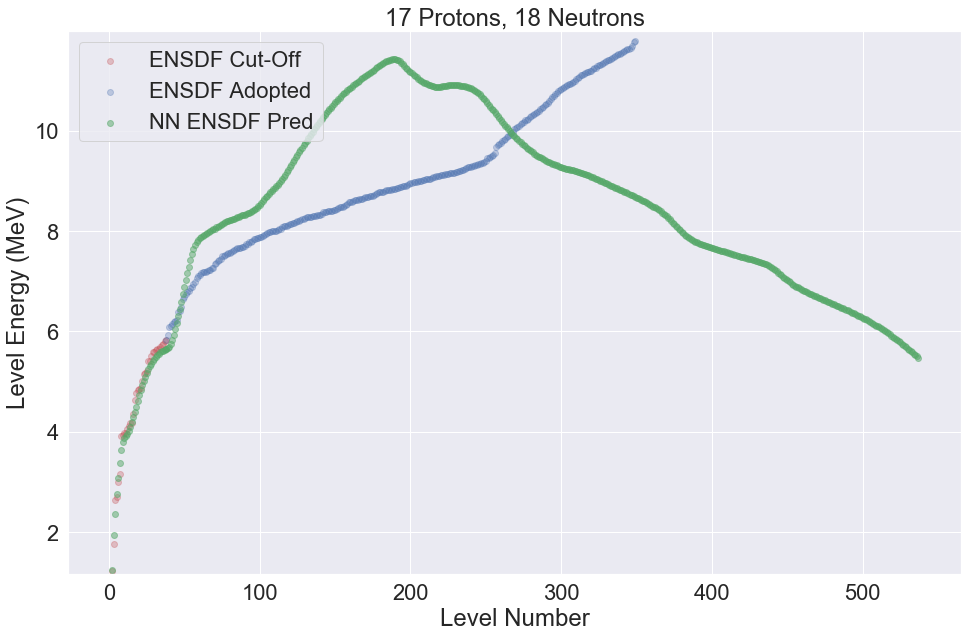

XS Tree vs EXFOR:
The MSE is:  0.022577838804830774
The R2-Score is:  0.987734795580994


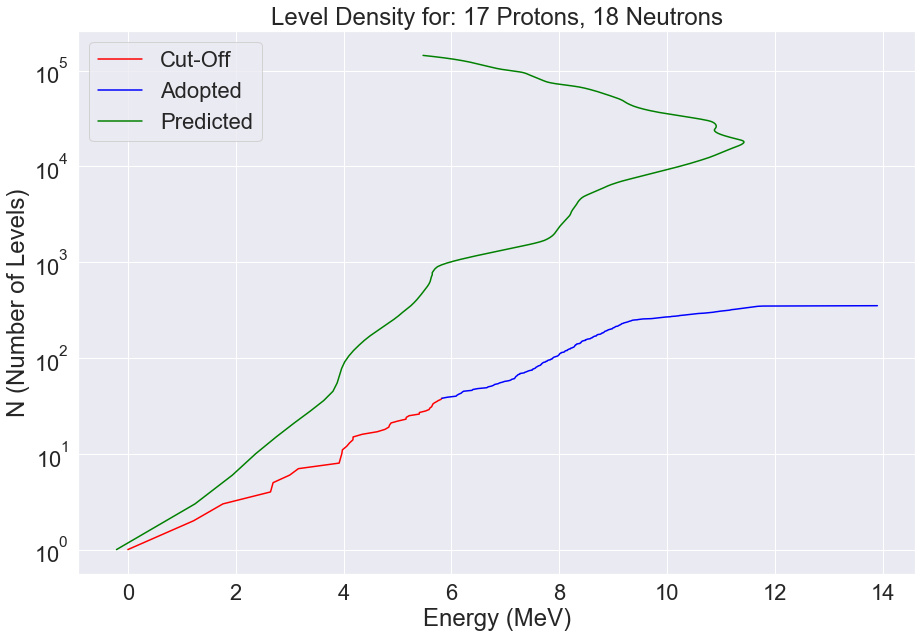

In [107]:
predicting_nuclear_xs(17, 35-17, size_histories['Large_GPU'].model, N=500, adopted=True, tf_dataset=True)

# Adding Regularization

As we know from Occam's Razor Principle the simplest one is the most likeley to be correct (the one with least amount of assumptions). Similar for neural networks, there will always be multiple models and therefore weights that can explain data. A simple model in this context is a model where the distribution of parameter values has less entropy. A common way to mitigate overfitting is to put constraints on the complexity of the NN by forcing weights to take small values which makes the distribution of such values more regular (weight regularization). This can be done by adding to the loss functionof the network a cost associated with having large weights. This costs can be:
- L1 Regularization: cost added proportional to the absolute value of the weights coefficients (L1 Norm). It pushes weights towards exactly 0 encouraging sparsity.
- L2 Regularization: proportional to the square of the value of the weights coefficients (L2 Norm). It is also called weight decay in NN context. It penalizes weight parameters without making them sparse since the weights go to 0 but are not 0. More common of the two. 

The `regularizers.l2(VALUE)` will make that every coefficient in the weight matrix of the layer will add VALUE * $weight_coefficients_value**2$ to the total loss of the network. In binary classification problems we monitor binary crossentropy since it doesnt have this regularization component mixed in.

Check if l2 is better than large at overfitting (same parameters)?

Dropout one of the most effective and most commonly used for NN. It is based on the fact that individual nodes in the N cannot rely on the output of the otherse, each node must output features that are useful on their own. The drooput layer randomly droppes out (set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of features that are zeroed out (between 0.2 to 0.5 usually). 

In [39]:
regularizer_histories = {}
# regularizer_histories['Tiny_GPU_1000'] = size_histories['Tiny_GPU_1000']

In [110]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.5477,  mae:1.8820,  mse:6.0110,  val_loss:4.6718,  val_mae:1.4269,  val_mse:3.5399,  
.........

In [111]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)             

In [40]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

....................................................................................................
Epoch: 3100, loss:0.9681,  mae:0.7244,  mse:0.8805,  val_loss:0.8366,  val_mae:0.6750,  val_mse:0.7506,  
....................................................................................................
Epoch: 3200, loss:0.9529,  mae:0.7183,  mse:0.8657,  val_loss:0.8329,  val_mae:0.6739,  val_mse:0.7465,  
....................................................................................................
Epoch: 3300, loss:0.9869,  mae:0.7257,  mse:0.8999,  val_loss:0.8336,  val_mae:0.6713,  val_mse:0.7482,  
....................................................................................................
Epoch: 3400, loss:0.9690,  mae:0.7213,  mse:0.8822,  val_loss:0.8268,  val_mae:0.6678,  val_mse:0.7401,  
....................................................................................................
Epoch: 3500, loss:0.9669,  mae:0.7176,  mse:0.8801,  val_loss:0.8220,  

In [119]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined_1000'] = compile_and_fit(combined_model, 'regularizers/combined_1000', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1000)              5000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1000)            

Text(0.5, 0, 'Epochs [Log Scale]')

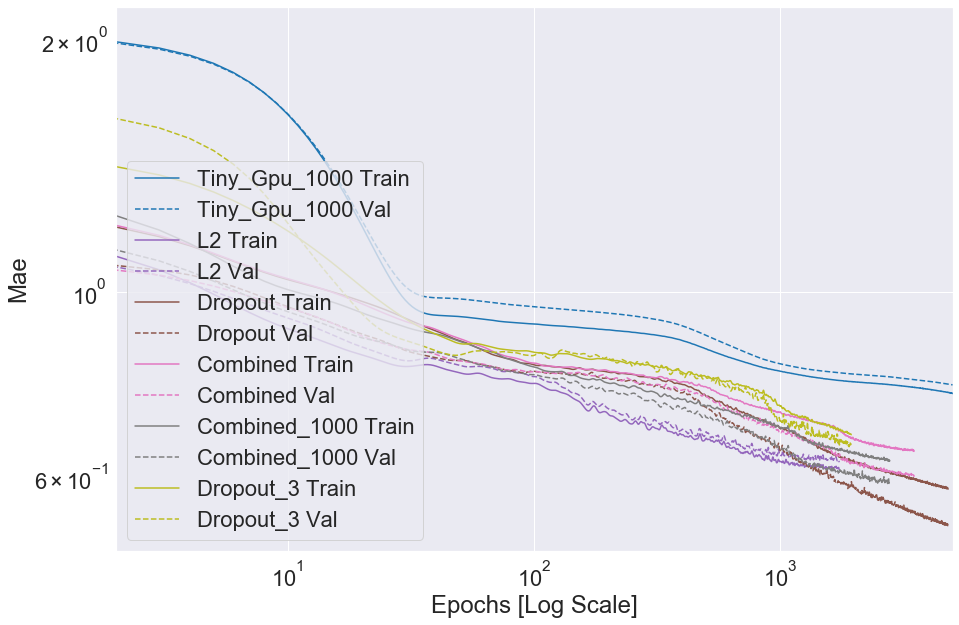

In [122]:
plt.figure(figsize=(15,10))
plotter.plot(regularizer_histories)
a = plt.xscale('log')
plt.xlim([2, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

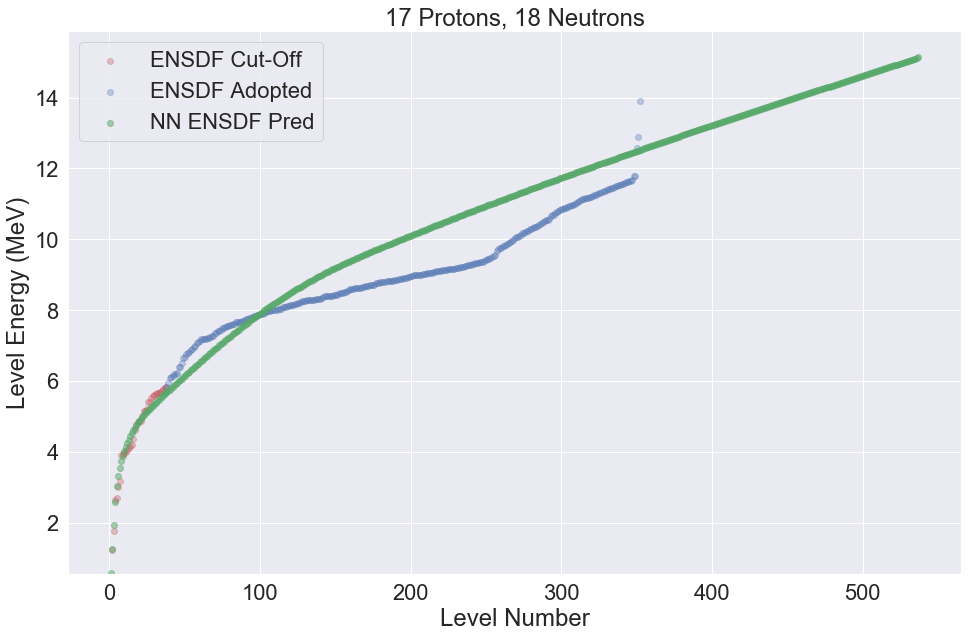

XS Tree vs EXFOR:
The MSE is:  0.045680737457149234
The R2-Score is:  0.975184357202382


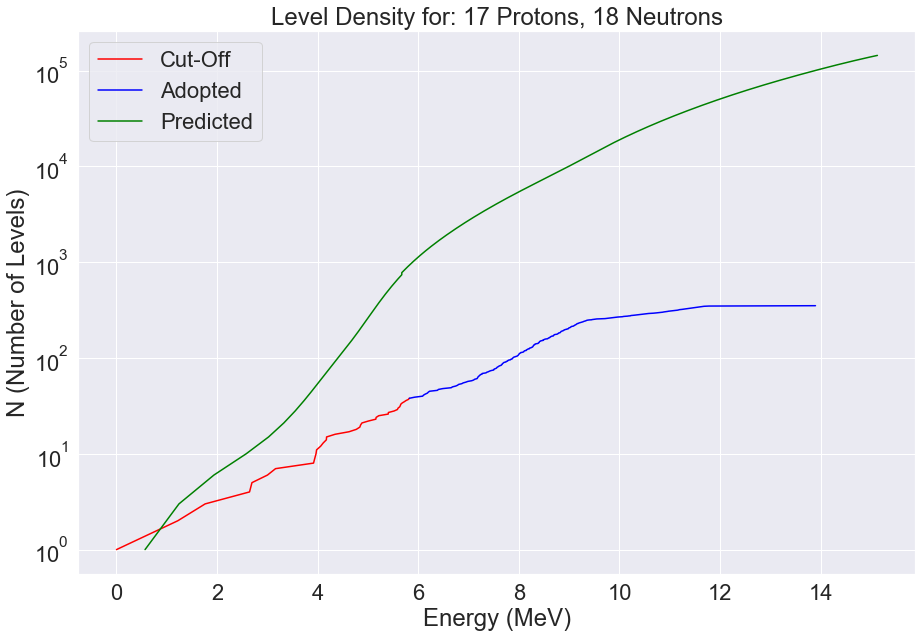

In [117]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['combined'].model, N=500, adopted=True, tf_dataset=True)

In [121]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout_3'] = compile_and_fit(dropout_model, 'regularizers/dropout_3', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)             

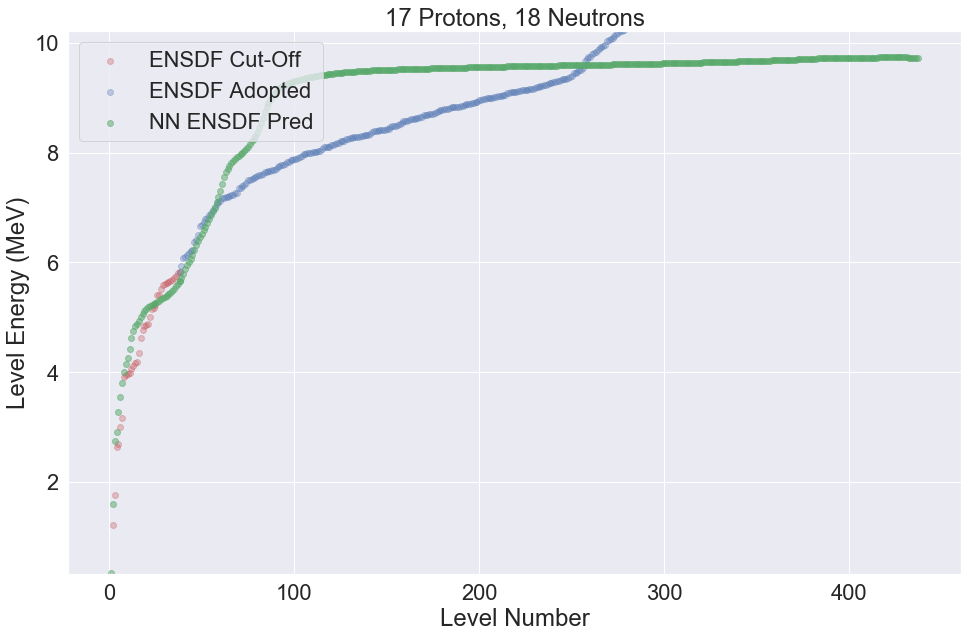

XS Tree vs EXFOR:
The MSE is:  0.15051733907346962
The R2-Score is:  0.9182328322786169


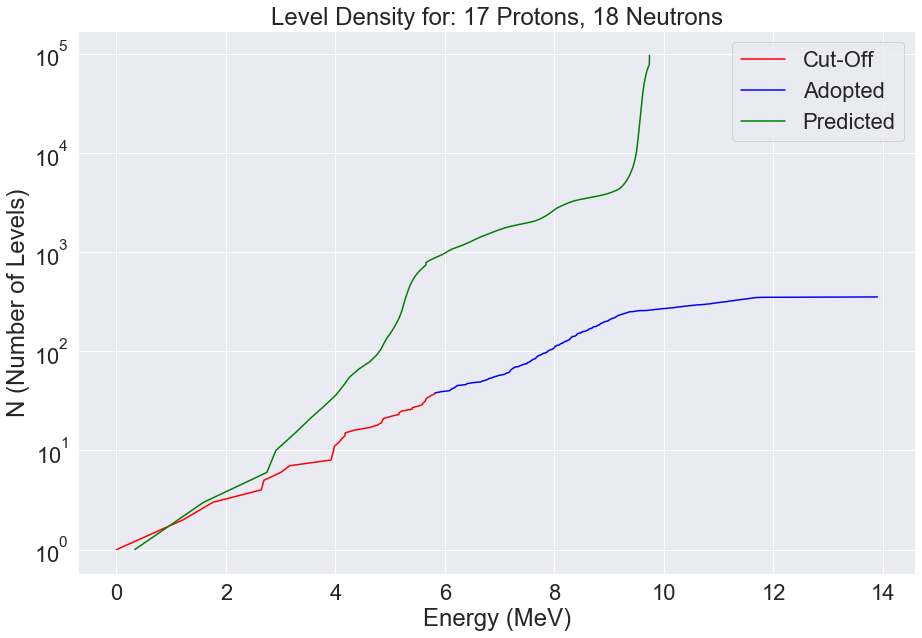

In [124]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['dropout_3'].model, N=400, adopted=True, tf_dataset=True)

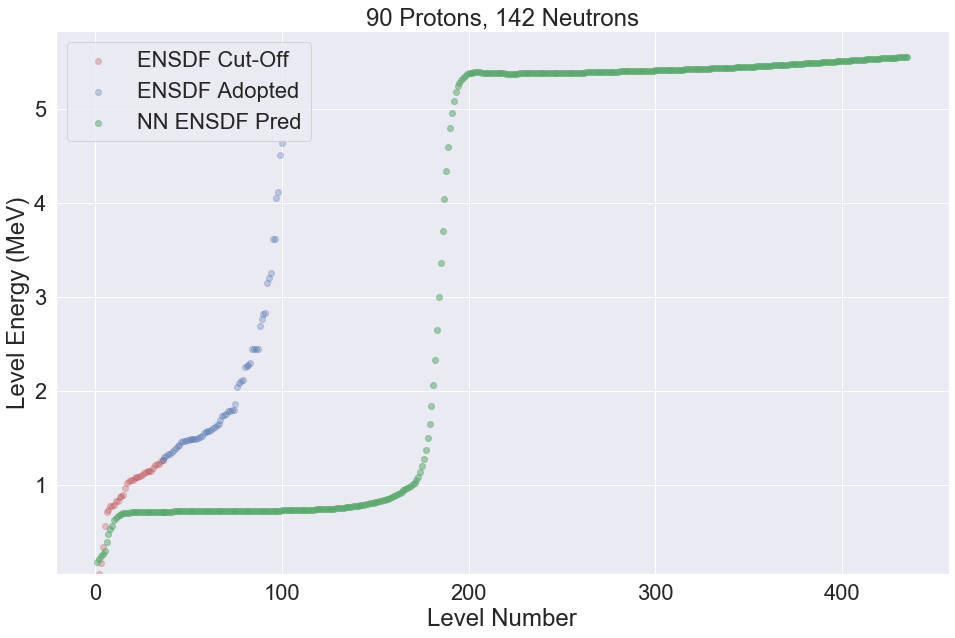

XS Tree vs EXFOR:
The MSE is:  0.12019854406462677
The R2-Score is:  -0.13596280084602475


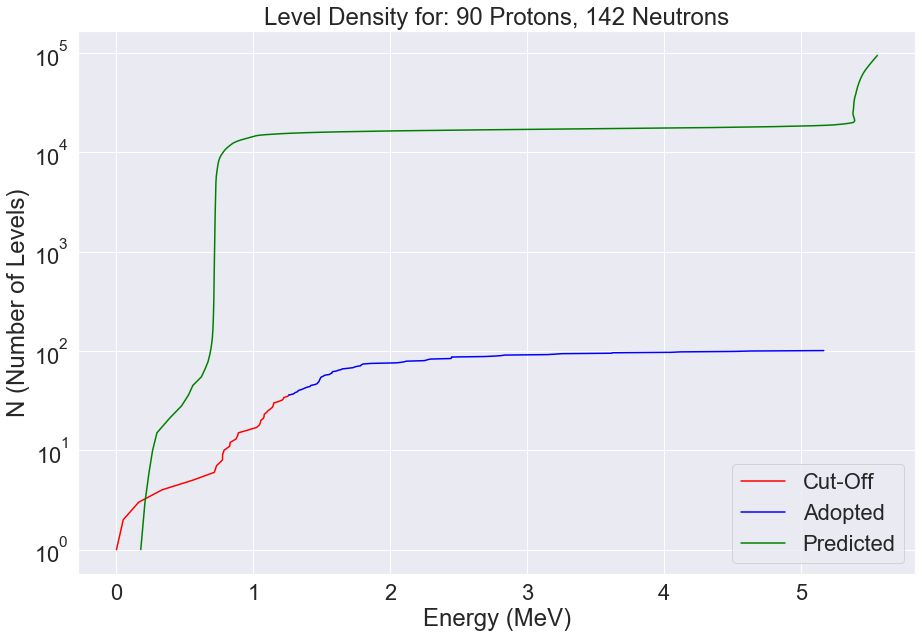

In [128]:
predicting_nuclear_xs(90, 232-90, regularizer_histories['dropout_3'].model, N=400, adopted=True, tf_dataset=True)

In [290]:
hist = pd.DataFrame(regularizer_histories['l2'].history)
hist['epoch'] = regularizer_histories['l2'].epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,3.423054,1.001607,2.655203,2.700178,0.975487,2.573845,295
296,3.360027,1.001824,2.592768,2.696059,0.989105,2.569116,296
297,3.418146,1.010282,2.651459,2.675017,0.977214,2.541878,297
298,3.681805,1.067090,2.915823,2.717230,0.984647,2.599586,298
299,3.674703,1.070685,2.909691,2.951144,1.073622,2.913288,299


## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

In [ ]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "./Checkpoints/L2/L2/"
# checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# regularizer_histories['l2'].model.save_weights(checkpoint_dir)

In [227]:
# def predicting_nuclear_xs(protons, neutrons, clf, N=0, adopted=False, tf_dataset=False):
#     ''' 
#     Used to plot predictions of the clf model for specific isotope (Z, N).
#     '''
#     # Extracting dataframe to make predictions and creating copy for evaluation
#     to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
#         by='Level_Number', ascending=True).drop(columns="Element_w_A")
#     to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
#         by='Level_Number', ascending=True).drop(columns=["Level_Energy", "Element_w_A"])
    
#     if N != 0:
#         last_level = to_plot.Level_Number.iloc[-1]
#         level_range = np.arange(last_level, last_level + N , 1)
#         to_infer2 = pd.DataFrame({"Level_Number": level_range})
#         for i in list(to_infer.columns)[1:]:
#                 to_infer2[i] = to_infer[i].values[1]
#         to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Level_Number', ascending=True)

#     if adopted == True:
#         to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Target_Neutrons"] == neutrons) & (df2["Level_Number"] >= last_level)].sort_values(
#             by='Level_Number', ascending=True).drop(
#             columns=["Element_w_A", "Spin", "Parity", "Target_Mass_Number", "Element"])
    
#     # Applying standard scaler method 
#     to_infer[to_scale] = scaler.transform(to_infer[to_scale])
        
#     infer_dataset = tf.data.Dataset.from_tensor_slices(
#         (to_infer.values)).batch(len(to_infer))
#     y_hat  = clf.predict(infer_dataset)

#     # Returning features to original values for plotting
#     to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
#     # Initializing Figure and Plotting 
#     plt.figure(figsize=(16,10))
#     true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
#     if adopted == True:
#         adopted_plot = plt.scatter(to_plot_2["Level_Number"], to_plot_2["Level_Energy"], alpha=0.3, c='g')
#     pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
#     plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#     plt.ylabel('Level Energy (MeV)')
#     plt.xlabel('Level Number')
#     plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
#     all_y = np.concatenate((to_plot["Level_Energy"], y_hat.flatten()))
#     minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
#     maximum_y = all_y.max() + all_y.max() * 0.05
#     plt.ylim(minimum_y, maximum_y)
#     plt.show()
    
#     if N != 0:
#         print("XS Tree vs EXFOR:")
#         print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
#         print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
#     else:
#         print("XS Tree vs EXFOR:")
#         print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
#         print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))    

#     if (N != 0 and adopted == True):
#         print("hello")
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
#         histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
#         histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
#         histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
#         histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
#         histogram_ad = pd.DataFrame(to_plot_2.Level_Energy.values, columns=["Level_Energy"])
#         histogram_ad.Level_Energy.hist(color="salmon", label="Adopted", **kwargs)
#         plt.legend()
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')
#         plt.yscale('log')
#     elif (N != 0 and adopted == False):
#         print('hello2')
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
#         histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
#         histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
#         histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
#         histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
#         plt.legend()
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')
#     else:
#         print("what")
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         histogram = pd.DataFrame(y_hat, columns=["Level_Energy"])
#         histogram.Level_Energy.hist(bins=division)
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')

To infer shape is  (538, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.04351830423937418
The R2-Score is:  0.9763590792689061
The MAE is:  0.15974338482957148
The Median-AE is:  0.11558089065551824


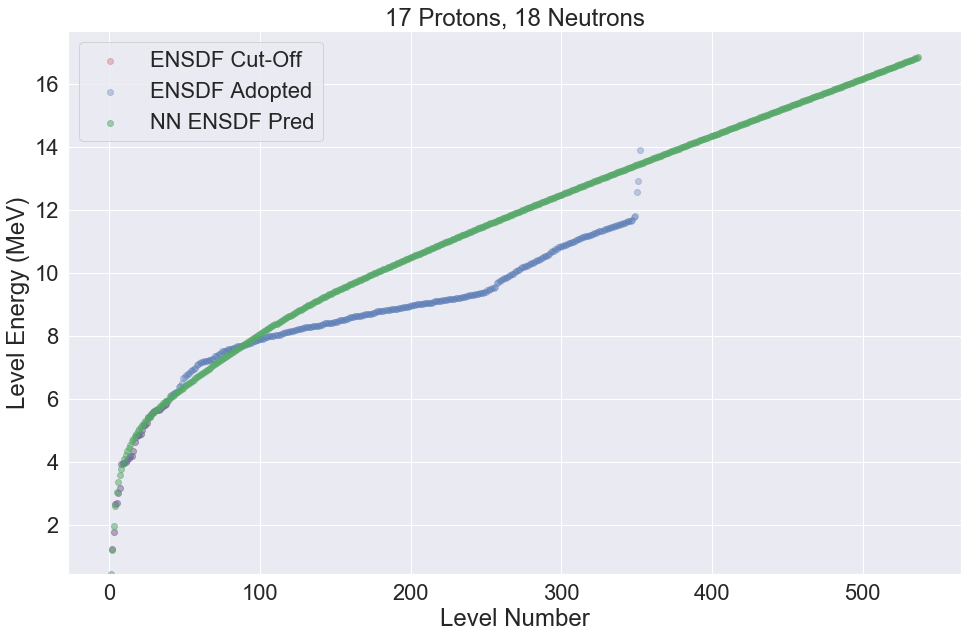

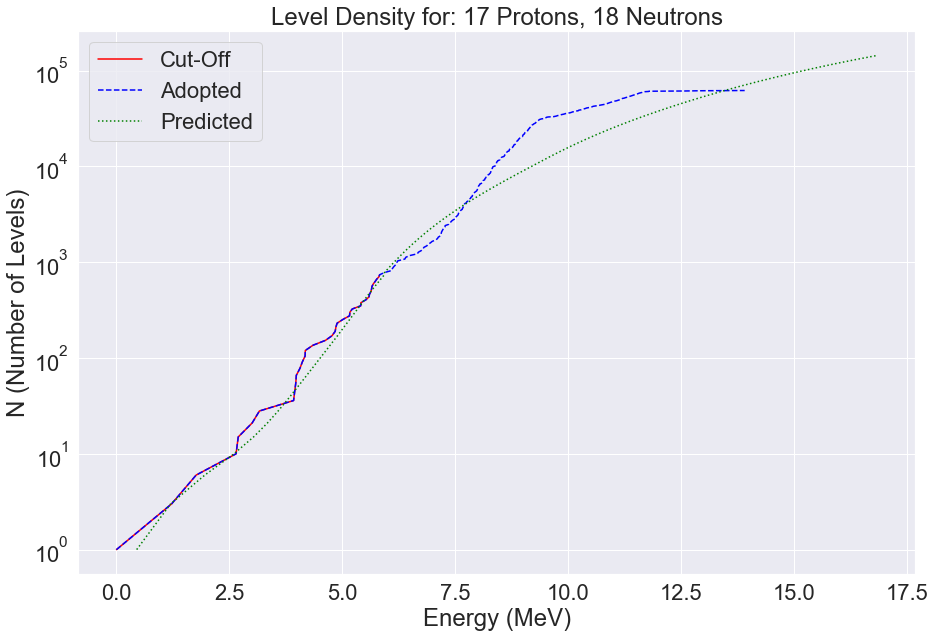

In [42]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, regularizer_histories['combined'].model, scaler, to_scale, 
                                               N=500, adopted=True, xg=False, tf_dataset=True, save=False, name="Cl35")

To infer shape is  (138, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.09880724701630299
The R2-Score is:  0.9463238668142637
The MAE is:  0.2340115800014296
The Median-AE is:  0.1592206284332276


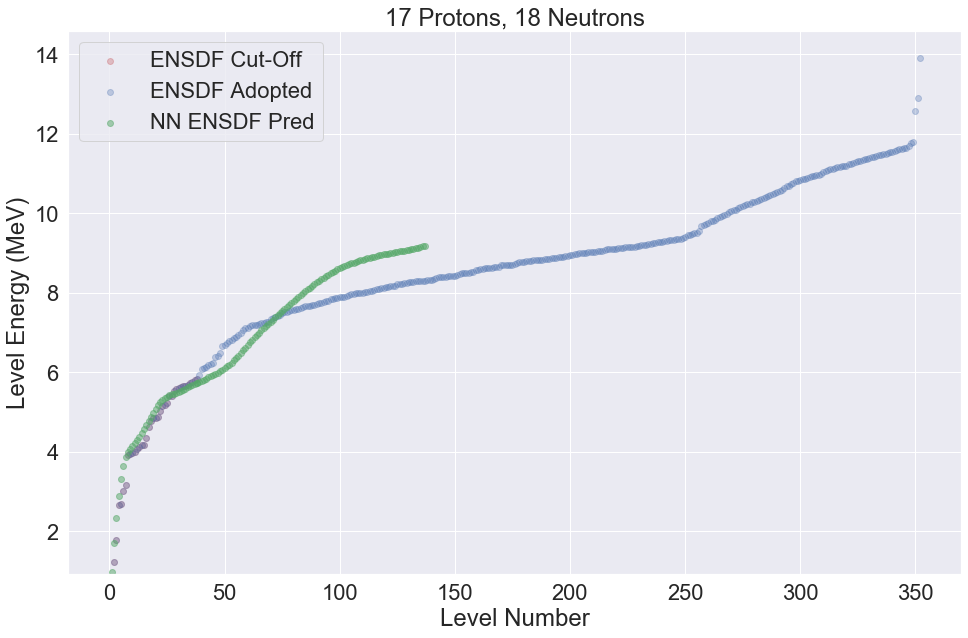

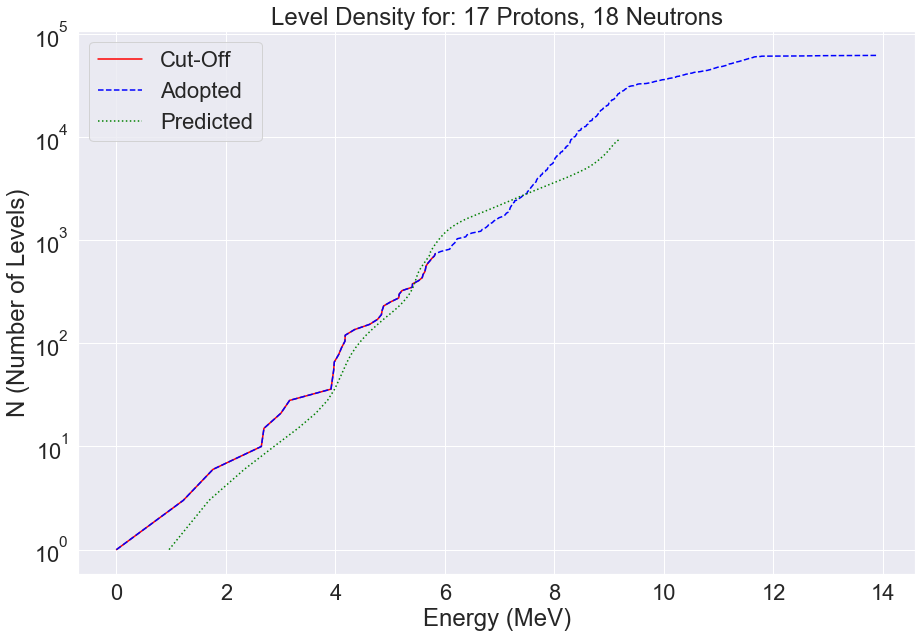

In [38]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, size_histories['Medium_GPU'].model, scaler, to_scale, 
                                               N=100, adopted=True, xg=False, tf_dataset=True, save=False, name="Cl35")